# Fit the spectrum of CTIO Data in November 2016
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : December 15th 2016

The goal is to extract the spectrum after the rotation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [2]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [3]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [6]:
%load_ext Cython

In [7]:
from IPython.display import Image, display

In [8]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [9]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [10]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [11]:
inputdir="./spectrum_fitsspec"
object_name='HD14943'

In [12]:
outputdir="./spectrum_calibspec"

In [13]:
ensure_dir(outputdir)

In [14]:
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10'

In [15]:
simspectrasummary='AllSimSpectra_'+object_name+'.fits'

## Location of corrected images
----------------------------------

In [16]:
input_filelist=os.listdir(inputdir) 

In [17]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [18]:
print input_filelist[0:5]

['finalSpectra_HD14943_2016_11_23T01_45_51_1.fits'
 'finalSpectra_HD14943_2016_11_23T01_46_55_2.fits'
 'finalSpectra_HD14943_2016_11_23T01_47_58_3.fits'
 'finalSpectra_HD14943_2016_11_23T01_52_42_4.fits'
 'finalSpectra_HD14943_2016_11_23T01_54_05_5.fits']


In [19]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [20]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [21]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [22]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [23]:
print indexes_files

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


In [24]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [25]:
sorted_numbers=indexes_files[sorted_indexes]

In [26]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116]


In [27]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [28]:
#sorted_files

## Build full filename
----------------------------

In [29]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [30]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [31]:
print sorted_filenames.shape

(117,)


## Acces to spectrum data
----------------------------------

In [32]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [33]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra = []
    all_rightspectra = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        left_spectrum=table_data.field('RawLeftSpec')
        right_spectrum=table_data.field('RawRightSpec')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_leftspectra.append(left_spectrum)
        all_rightspectra.append(right_spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra

In [34]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra=BuildRawSpec(sorted_files,sorted_numbers,object_name)

## Show Spectra
-----------------------

In [35]:
len(all_rightspectra)

117

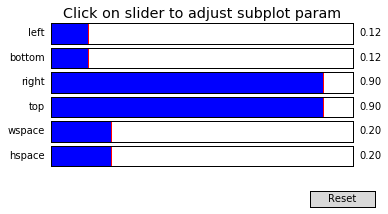

In [36]:
plt.subplot_tool() 

In [37]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
def ShowSpectra(all_spectra,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,200.)
        axarr[iy,ix].set_xlim(0.,500.)
        axarr[iy,ix].grid(True)
      
    #title='spectra'
    #plt.suptitle(title,size=16)
   

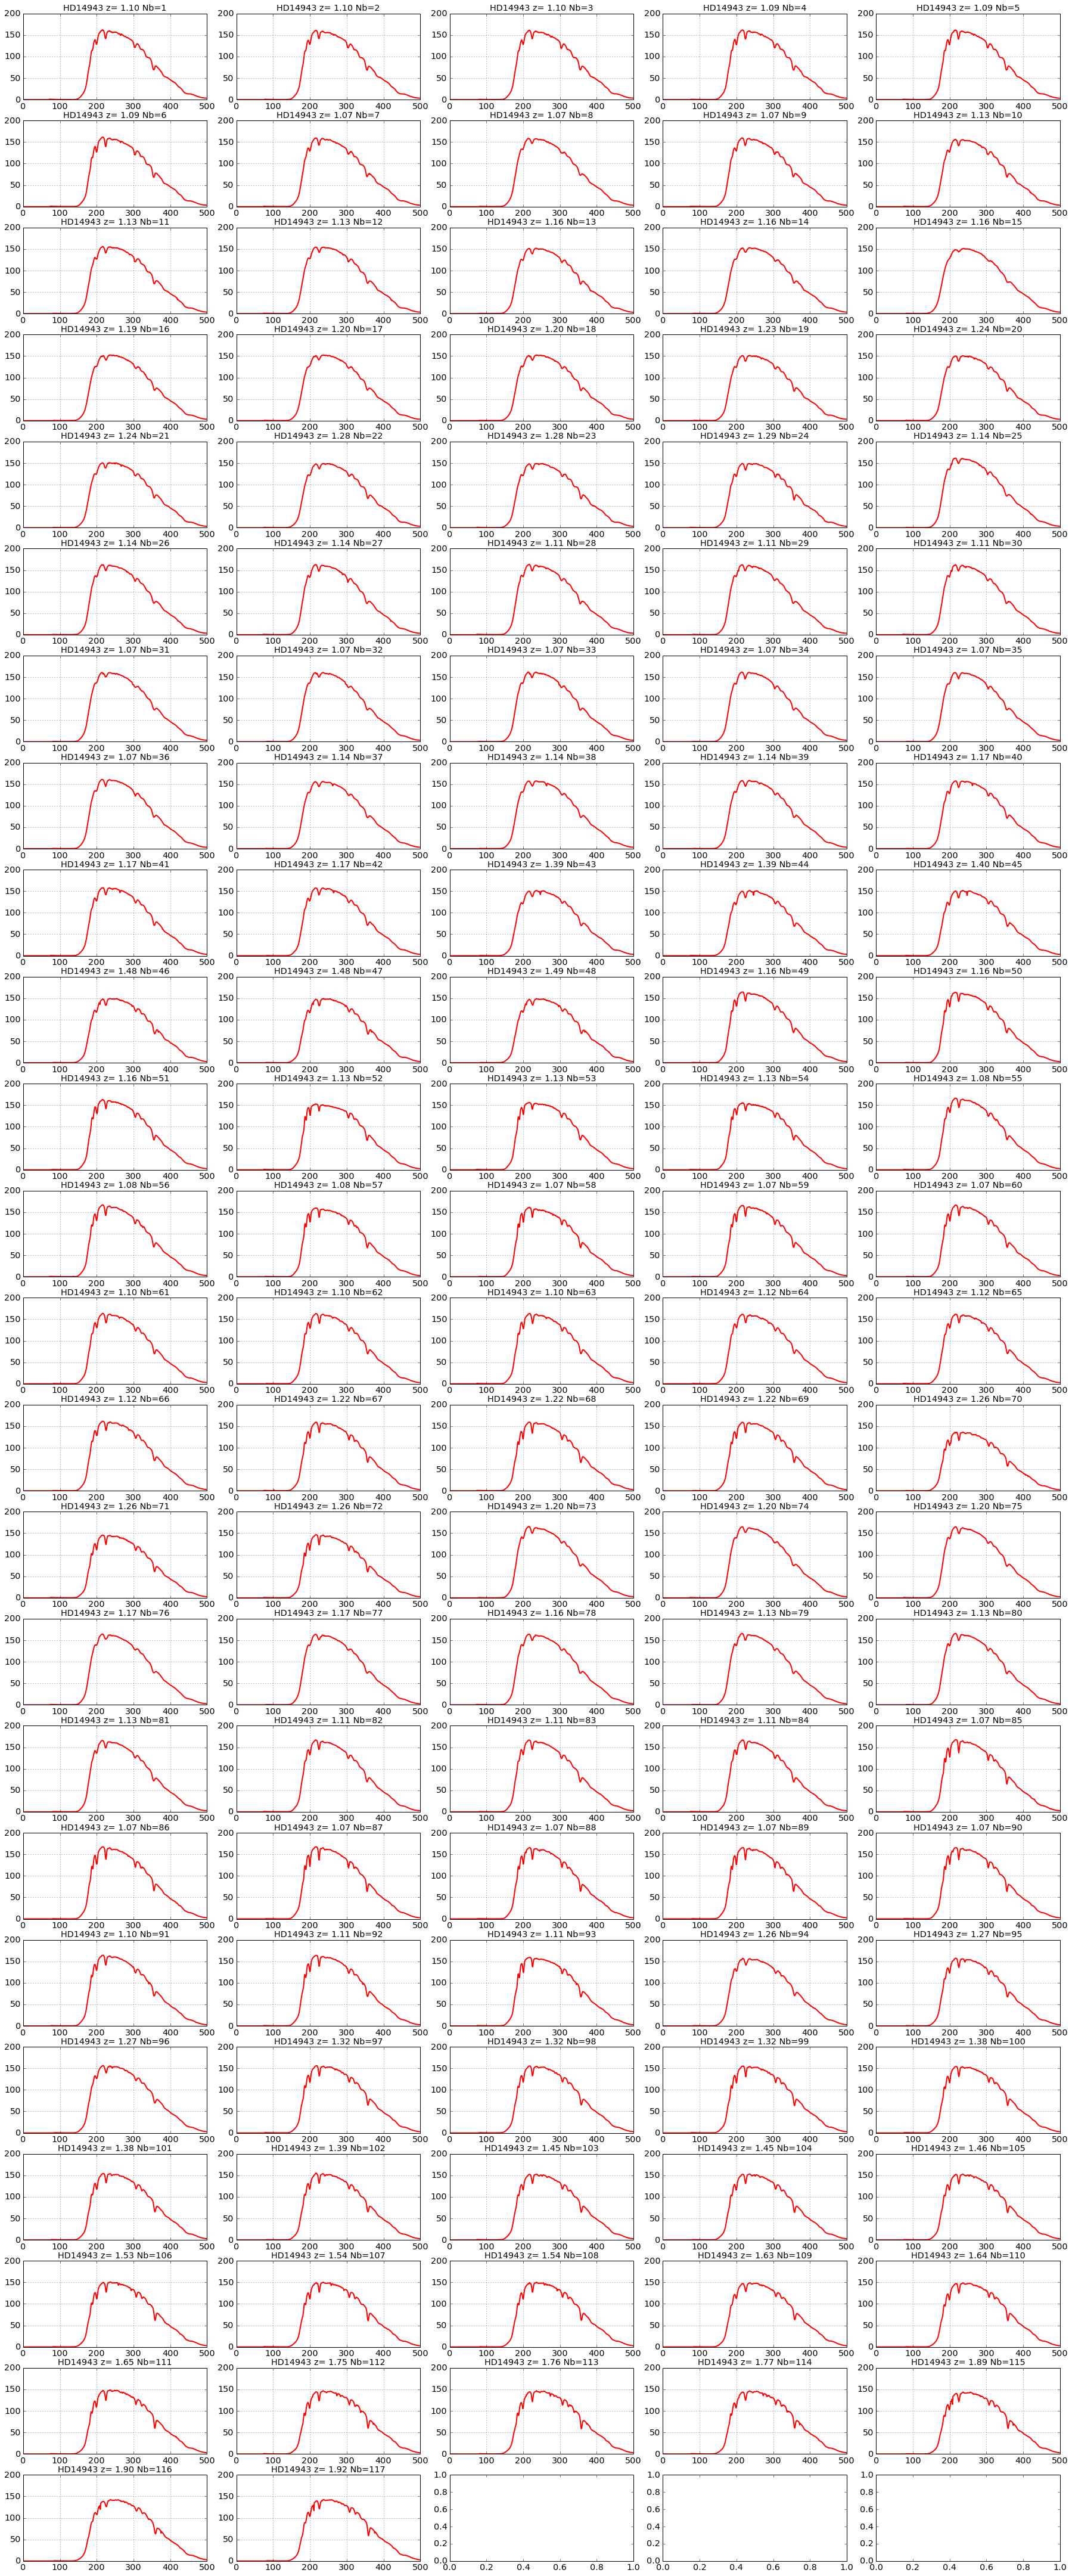

In [38]:
ShowSpectra(all_rightspectra,all_titles,object_name)

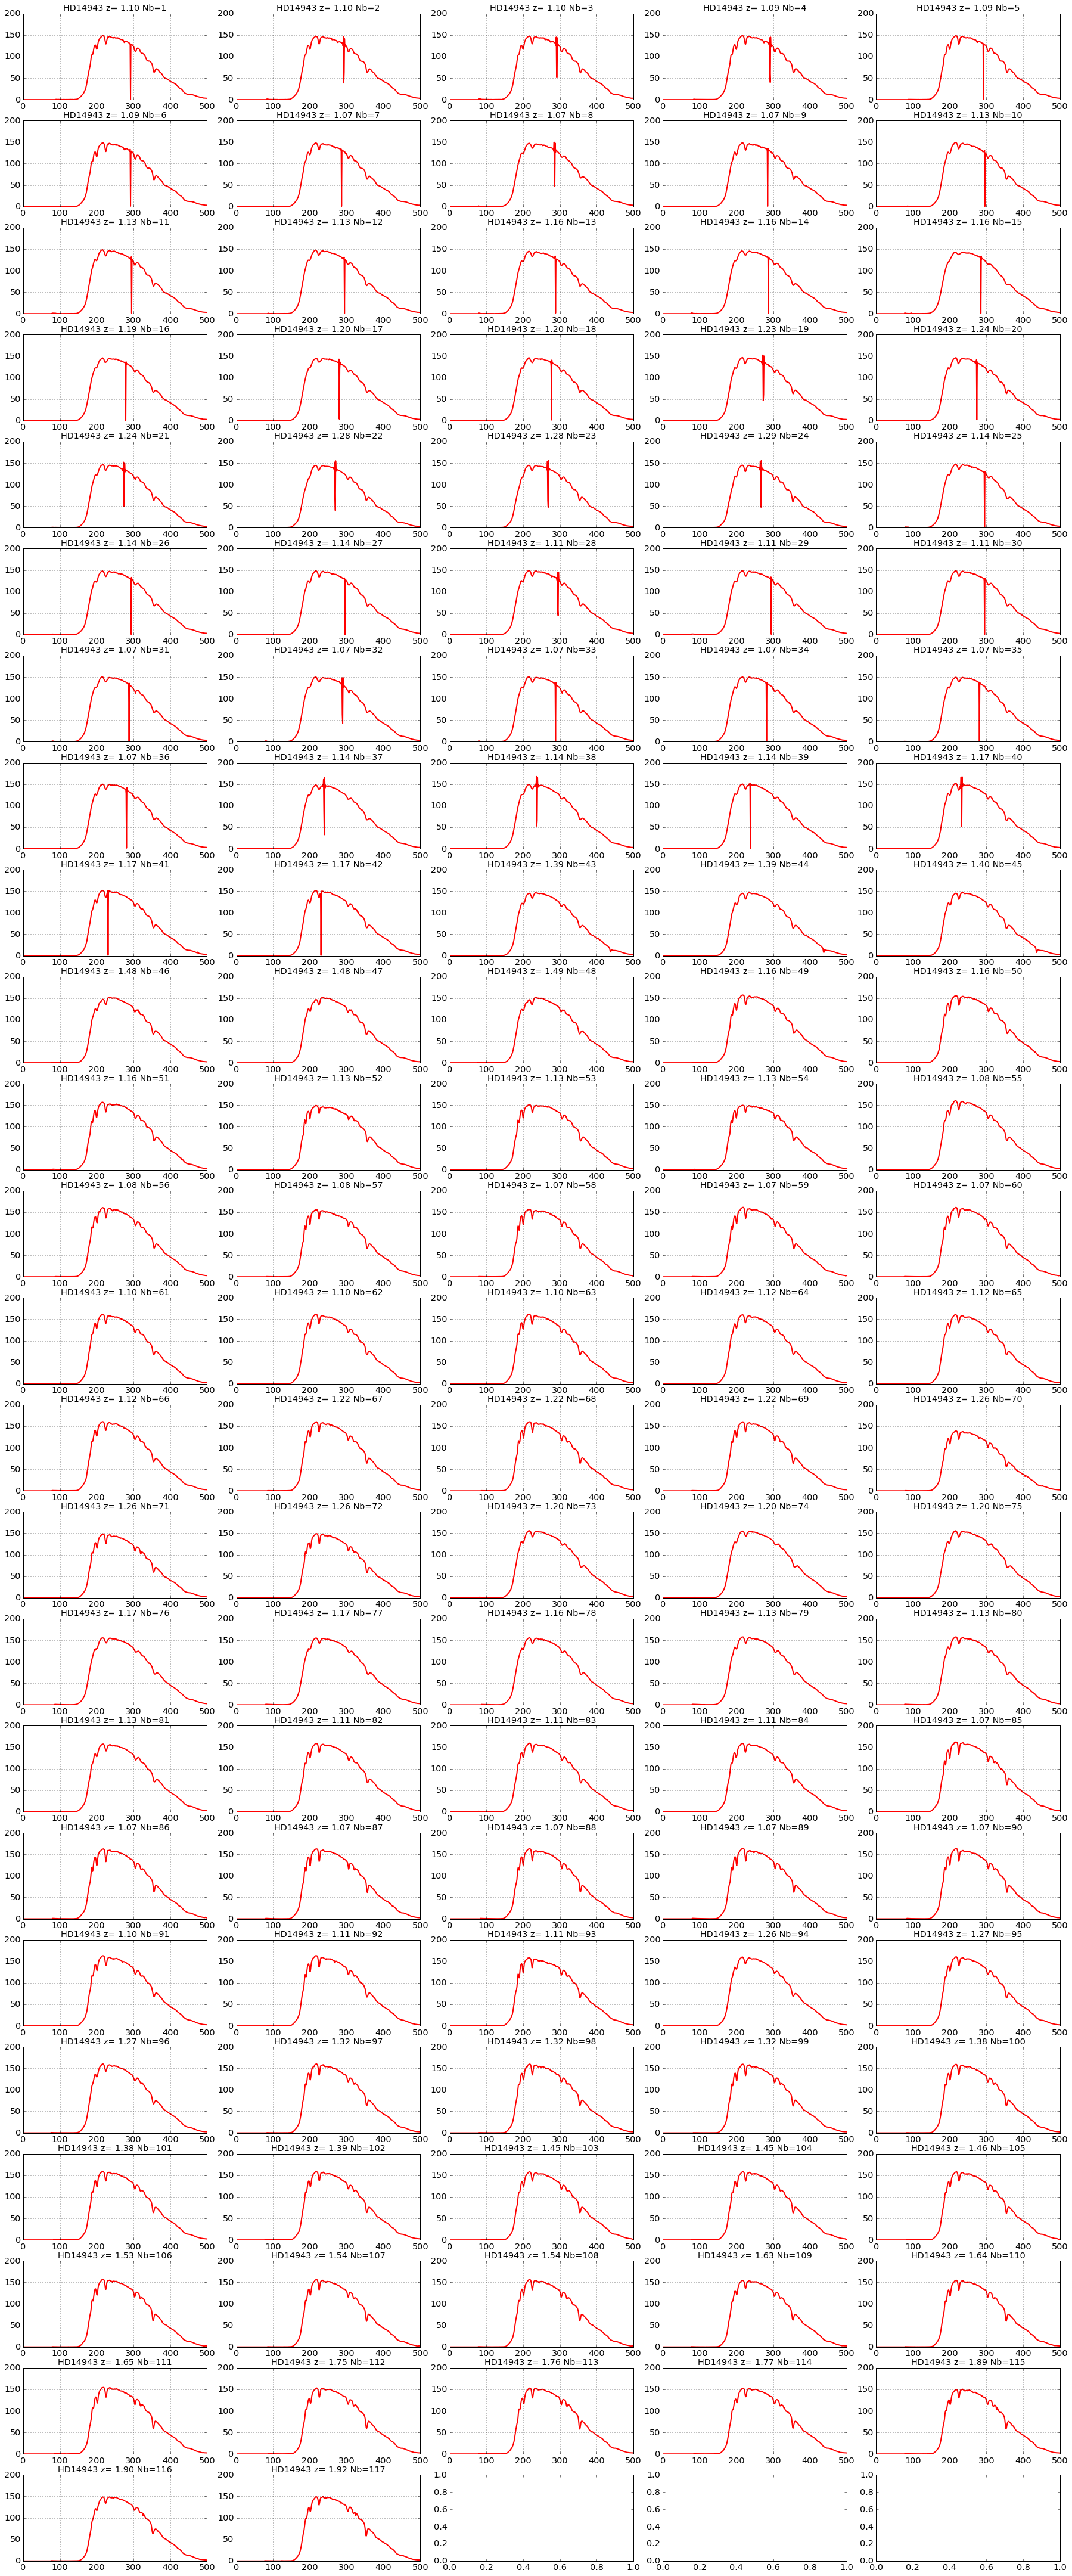

In [39]:
ShowSpectra(all_leftspectra,all_titles,object_name)

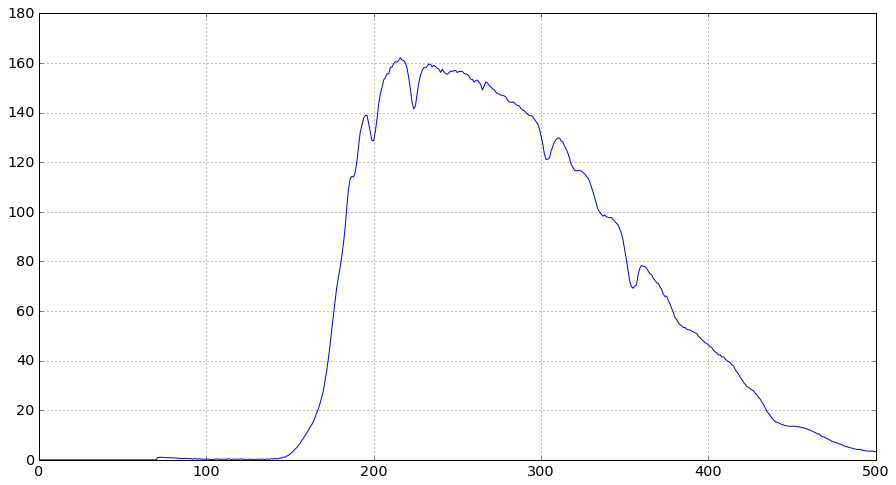

In [40]:
plt.figure(figsize=(15,8))
plt.plot(all_rightspectra[0])
plt.xlim(0,500)
plt.grid(True)

## Read the simulated spectra

In [41]:
inputsim_filelist=os.listdir(simspecdir) 

In [42]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [43]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD14943_Nev100_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev101_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev102_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev103_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev104_y2016_m10_aver_spectra.fits']


In [44]:
print re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m10_aver_spectra.fits',inputsim_filelist[0])

['100']


In [45]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [46]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m10_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [47]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [48]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [49]:
print indexes_simfiles

[100 101 102 103 104 105 106 107 108 109  10 110 111 112 113 114 115 116
 117  11  12  13  14  15  16  17  18  19   1  20  21  22  23  24  25  26
  27  28  29   2  30  31  32  33  34  35  36  37  38  39   3  40  41  42
  43  44  45  46  47  48  49   4  50  51  52  53  54  55  56  57  58  59
   5  60  61  62  63  64  65  66  67  68  69   6  70  71  72  73  74  75
  76  77  78  79   7  80  81  82  83  84  85  86  87  88  89   8  90  91
  92  93  94  95  96  97  98  99   9]


In [50]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [51]:
sorted_simindexes

array([ 28,  39,  50,  61,  72,  83,  94, 105, 116,  10,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  11,  12,  13,  14,  15,  16,  17,  18])

In [52]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [53]:
print sorted_simnumbers # check

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


In [54]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [55]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev1_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev2_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev3_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev4_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev5_y2016_m10_aver_spectra.fits']


In [56]:
hdu_list=fits.open(sorted_simfiles[49])
header=hdu_list[0].header

In [57]:
print header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  OBJ_NAME= 'HD14943 '                                                            AIRMASS =    1.156999945640564                                                  UNITS   = 'wavelength in nm'                                                    DATE    = '2016-11-25T00:51:28.239'                                             EXPOSURE=                 40.0                                                  FILENAME= '2016_11_25T00_52_10'                                                 COMMENT Prediction of observable SPECTRA                                        END                                                                                                                     

In [58]:
 table_data=hdu_list[1].data

In [59]:
print table_data.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'Atmosphere'; format = 'E'
    name = 'QE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
)


In [60]:
simwavelength = table_data.field('WAVELENGTH')
simsed        = table_data.field('SEDcalspec')
simatm        = table_data.field('Atmosphere')
simqe         = table_data.field('QE')
simspectra    = table_data.field('SEDxQExATM')

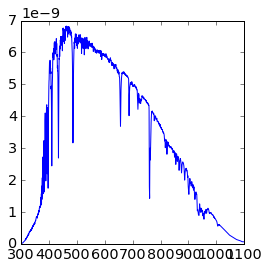

In [61]:
plt.plot(simwavelength,simspectra )

In [62]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        print idx
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [63]:
# crash because it blows up fits IO capability : too many files open
#all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

In [64]:
# better open a singel file produced by view_SimSpectrum

hdu_list=fits.open(simspectrasummary)
header=hdu_list[0].header
print header

simspectra_data=hdu_list[0].data

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1888                                                  NAXIS2  =                  118                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

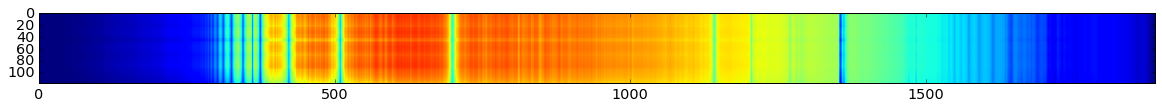

In [65]:
plt.figure(figsize=(20,20))
plt.imshow(simspectra_data[:,:],vmin=0,vmax=8e-9)

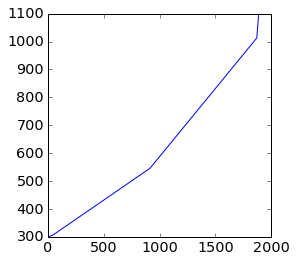

In [66]:
plt.plot(simspectra_data[0,:])

In [67]:
wl_O2Aline=759.37
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175

#wl_Naline=589.592+1
#wl_Heline=587.5618-1


#wl_Hgline=546.073
#wl_Feline=527.039

## Comparison of spectra

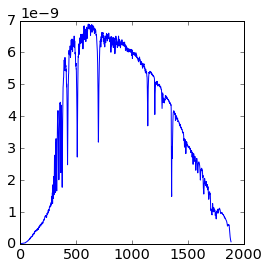

In [68]:
plt.plot(simspectra_data[2,:])

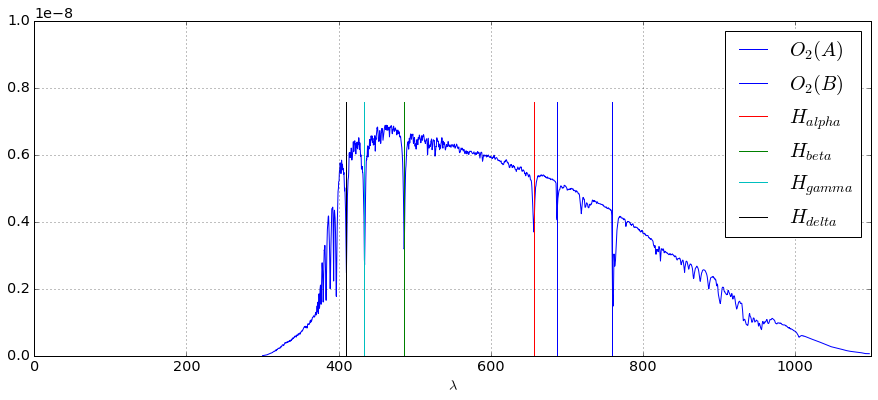

In [69]:
ymax=simspectra_data[2,:].max()*1.1
ymin=simspectra_data[2,:].min()
plt.figure(figsize=(15,6))
plt.plot(simspectra_data[0,:],simspectra_data[2,:])

plt.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
plt.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
plt.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
plt.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
plt.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
plt.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)

plt.legend(loc='best',fontsize=20)
plt.ylim(0.,1e-8)
plt.xlim(0,1100)
plt.xlabel("$\lambda$")
plt.grid(True)

# define the range where to search the minimum

In [70]:
pixminO2=350
pixmaxO2=360

pixminHa=300
pixmaxHa=310

pixminHb=220
pixmaxHb=230

pixminHg=195
pixmaxHg=205

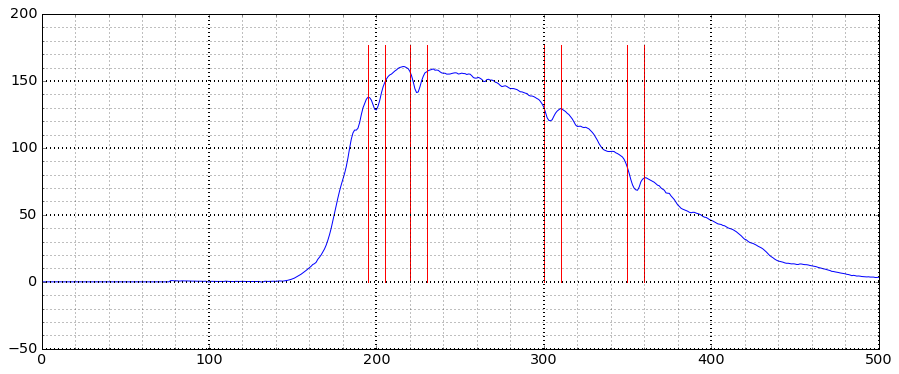

In [71]:
ymax=all_rightspectra[1].max()*1.1
ymin=0

fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(all_rightspectra[1])
ax.set_xlim(0,500)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
# O2 boundary
ax.plot([pixminO2,pixminO2],[ymin,ymax],'r-')
ax.plot([pixmaxO2,pixmaxO2],[ymin,ymax],'r-')

ax.plot([pixminHa,pixminHa],[ymin,ymax],'r-')
ax.plot([pixmaxHa,pixmaxHa],[ymin,ymax],'r-')

ax.plot([pixminHb,pixminHb],[ymin,ymax],'r-')
ax.plot([pixmaxHb,pixmaxHb],[ymin,ymax],'r-')

ax.plot([pixminHg,pixminHg],[ymin,ymax],'r-')
ax.plot([pixmaxHg,pixmaxHg],[ymin,ymax],'r-')

In [86]:
def FindO2line(spectrum):
    peak_O2=np.min(spectrum[pixminO2:pixmaxO2])
    indexes_O2=np.where(spectrum==peak_O2)
    theO2index=np.where(np.logical_and(np.greater(indexes_O2,pixminO2), np.less(indexes_O2,pixmaxO2)), indexes_O2,0)
    return theO2index, peak_O2

In [92]:
def FindHaline(spectrum):
    peak_Ha=np.min(spectrum[pixminHa:pixmaxHa])
    indexes_Ha=np.where(spectrum==peak_Ha)
    theHaindex=np.where(np.logical_and(np.greater(indexes_Ha,pixminHa), np.less(indexes_Ha,pixmaxHa)), indexes_Ha,0)
    return theHaindex, peak_Ha

In [95]:
def FindHbline(spectrum):
    peak_Hb=np.min(spectrum[pixminHb:pixmaxHb])
    indexes_Hb=np.where(spectrum==peak_Hb)
    theHbindex=np.where(np.logical_and(np.greater(indexes_Hb,pixminHb), np.less(indexes_Hb,pixmaxHb)), indexes_Hb,0)
    return theHbindex, peak_Hb

In [99]:
def FindHgline(spectrum):
    peak_Hg=np.min(spectrum[pixminHg:pixmaxHg])
    indexes_Hg=np.where(spectrum==peak_Hg)
    theHgindex=np.where(np.logical_and(np.greater(indexes_Hg,pixminHg), np.less(indexes_Hg,pixmaxHg)), indexes_Hg,0)
    return theHgindex, peak_Hg

In [100]:
theO2index, peak_O2=FindO2line(all_rightspectra[1])
theHaindex, peak_Ha=FindHaline(all_rightspectra[1])
theHbindex, peak_Hb=FindHbline(all_rightspectra[1])
theHgindex, peak_Hg=FindHgline(all_rightspectra[1])

In [101]:
print  theO2index,theHaindex, theHbindex,theHgindex

[[356]] [[304]] [[224]] [[200]]


In [113]:
def FindLines(spec):
    indexO2,peak_O2=FindO2line(spec)
    indexHa,peakHa=FindHaline(spec)
    indexHb,peakHb=FindHbline(spec)
    indexHg,peakHg=FindHgline(spec)
    return indexO2[0][0],indexHa[0][0],indexHb[0][0],indexHg[0][0]

In [121]:
lpix=FindLines(all_rightspectra[1])

In [133]:

YY= np.array([wl_O2Aline,wl_Haline,wl_Hbline,wl_Hgline])
XX=np.array([np.array(lpix)]).flatten()

In [134]:
YY

array([ 759.37 ,  656.281,  486.134,  434.047])

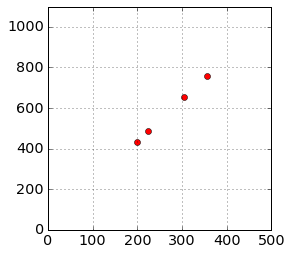

In [140]:
plt.plot(XX,YY,'ro')
plt.xlim(0,500)
plt.ylim(0,1100)
plt.grid(True)

In [ ]:
index_O2=np.where()

peak_O2=np.min(specsum[1315:1365])
indexes_O2=np.where(specsum==peak_O2)
print indexes_O2, peak_O2

In [ ]:
ymax=all_leftspectra[1].max()*1.1
ymin=0

fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(all_leftspectra[1])
ax.set_xlim(0,500)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
# O2 boundary
ax.plot([pixminO2,pixminO2],[ymin,ymax],'r-')
ax.plot([pixmaxO2,pixmaxO2],[ymin,ymax],'r-')

ax.plot([pixminHa,pixminHa],[ymin,ymax],'r-')
ax.plot([pixmaxHa,pixmaxHa],[ymin,ymax],'r-')

ax.plot([pixminHb,pixminHb],[ymin,ymax],'r-')
ax.plot([pixmaxHb,pixmaxHb],[ymin,ymax],'r-')

ax.plot([pixminHg,pixminHg],[ymin,ymax],'r-')
ax.plot([pixmaxHg,pixmaxHg],[ymin,ymax],'r-')

### prepare outputfilename

In [ ]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^finalSpectra__(.*)',short_infilename)
    short_outfilename='fittedSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [ ]:
newfullfilenames

### Save outputfilename

In [ ]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=spectra_right[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)

In [ ]:
!ls

In [ ]:
# !ls -l cut_fitsimages